In [1]:
### To install sib as a python package look at the sib documentation 

import sys
#sys.path.insert(0,'./src/')
#simulator_path = "../covid_de/sim/" ##change simulatio path here 
sys.path.insert(0,'src/')
simulator_path = "../simulator/sim/" ##change simulatio path here 
sys.path.insert(0, '../simulator/sim/lib/') # we need distributions.py
sys.path.insert(0,simulator_path)
sys.path.insert(0, "../epidemic_mitigation/src/") # correct rankers

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import json, log, logging, loop_mtpp
from importlib import reload
import imp
from math import exp
import pickle
#sys.path.insert(0,'./src/loop_ranker')
from lib.mobilitysim import MobilitySimulator
import loop_mtpp
from mtpp_utils import contacts_cg
from distributions import CovidDistributions

#logging
data_path = '../simulator/sim/lib/mobility/'

output_dir = "output_Tubingen_pop1_site1/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

Log setup complete


### Mobility simulation

In [2]:
beta = 0.05  # from paper
country = 'GER'
distr = CovidDistributions(country)
# with open(data_path + 'Isle_of_Wight_settings_pop10_site5.pk', 'rb') as fp:
with open(data_path + 'Tubingen_settings_pop1_site1.pk', 'rb') as fp:
    mob_kwargs = pickle.load(fp)

mob_kwargs["delta"] = 0.2554120904376099
T = 31
seed_mob = 1
t_unit = 24
t_res = 0.25  # drop contacts with a duration < t_res (in hours)
max_time = T * t_unit
mob = MobilitySimulator(**mob_kwargs)
mob.verbose = True
out = mob.simulate(max_time=max_time, seed=seed_mob)
N = mob.num_people
# print(N)


Simulate mobility for 744.00 time units... 

## Set testing and quarantine rules

In [3]:
# n_indiv=np.ceil(mob_kwargs['num_people_unscaled']/mob_kwargs['downsample_pop'])
n_seeds = {'expo': 3, 'iasy': 4, 'ipre': 5}  # select initial infected seeds
num_test_random = 50  # number of random tests per day
fraction_sym_obs = 0.5  # fraction of Symptomatic tested positive
initial_steps = 30  # starting time of intervention
delta_days = 1  # intervention every delta_days days
test_HH = False
quarantine_HH = False
adoption_fraction = 1.0
probability_th = 0.0
adapt_th = False



## Set the inference algorithm class

In [4]:
import matplotlib.pyplot as plt
import sib
import scipy

from rankers import sib_rank, greedy_rank, mean_field_rank
from tqdm.notebook import tqdm
from scipy.stats import gamma
sib.set_num_threads(6)


mu = 1/12
prob_seed = 1/N
prob_sus = 0.5
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-6
fp_rate = 0.0
fn_rate = 0.0

rankers = {}


rankers["MF"] = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = mu,
                lamb = 1.0
                )
                
rankers["greedy"] = greedy_rank.GreedyRanker(
                 include_S = True,
                tau=10)

rankers["no_intervention"] = None

k_rec_gamma = 62.484380808876004
scale_rec_gamma = 0.2992112296058585
t0 = distr.incubation_mean_of_lognormal - \
    distr.median_infectious_without_symptom
alpha = 2.0
tau = 0

prob_i = sib.PiecewiseLinear(sib.RealParams(
    list(scipy.special.expit(alpha*(range(T+1) - t0*np.ones(T+1))))))
prob_r = sib.PiecewiseLinear(sib.RealParams(
    list(scipy.stats.gamma.sf(range(T+1), k_rec_gamma, scale=scale_rec_gamma))))

rankers["sib"] = sib_rank.SibRanker(
    params=sib.Params(
        prob_i=prob_i,
        prob_r=prob_r,
        pseed=pseed,
        psus=psus,
        pautoinf=pautoinf),
    maxit0=20,
    maxit1=20,
    tol=1e-3,
    memory_decay=1e-5,
    window_length=21,
    tau=tau,
    fnr=fn_rate,
    fpr=fp_rate

)


In [5]:
ress = {}
for num_test_algo in [300]: #number of test per day by ranking
    for seed in [0]:
        print(num_test_algo, seed)
        for s in list(rankers.keys()):
            data = {"algo":s}
            if s== "no_intervention":
                    res_s = loop_mtpp.free_mtpp(mob,
                    country  = country,
                    beta = beta,
                    T = T,
                    seed=seed,
                    logger = logging.getLogger(f"iteration.{s}"),
                    data = data,
                    initial_counts = n_seeds,
                    name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                    output_dir = output_dir,
                     )
            else:
                    res_s = loop_mtpp.loop_mtpp(mob,
                    rankers[s],
                    country  = country,
                    T = T,
                    seed=seed,
                    logger = logging.getLogger(f"iteration.{s}"),
                    data = data,
                    initial_steps = initial_steps, 
                    num_test_random = num_test_random,
                    num_test_algo = num_test_algo,
                    fraction_sym_obs = fraction_sym_obs,
                    initial_counts = n_seeds,
                    beta = beta,
                    test_HH = test_HH,
                    quarantine_HH = quarantine_HH,
                    name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                    output_dir = output_dir,
                    save_every_iter = 1,
                    adoption_fraction = adoption_fraction,
                    probability_th = probability_th,
                    adapt_th = adapt_th,
                    fp_rate = fp_rate,
                    fn_rate = fn_rate
                 )
            ress[s] = res_s    
        del res_s


300 0
Starting with guys:  {'expo': [53551, 44855, 21873], 'iasy': [70851, 41074, 26964, 45836], 'ipre': [54521, 37051, 56361, 58576, 18919]}
t: 24.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:0



[Reached max time: 24h (1d)]
All raw contacts 985818
Contacts at midnight  35154
Contacts collected by coarse-graining  19478
Contacts in multiple days  0
Coarse-grained contacts  1001494
Missing contacts  0
Asymmetric contacts  0


numexpr.utils: INFO     Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
numexpr.utils: INFO     Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils: INFO     NumExpr defaulting to 8 threads.
iteration.MF: INFO     adding contacts in the interval [0, 24]
iteration.MF: INFO     number of unique contacts: 966340
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90499.0, 40.0, 0.0)
iteration.MF: INFO     AUC_I : 0.845
iteration.MF: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 22 free as birds (+0)


t: 312.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:12



[Reached max time: 312h (13d)]
All raw contacts 1089798
Contacts at midnight  70226
Contacts collected by coarse-graining  23870
Contacts in multiple days  0
Coarse-grained contacts  1136154
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [288, 312]
iteration.MF: INFO     number of unique contacts: 1065466
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90498.0, 41.0, 0.0)
iteration.MF: INFO     AUC_I : 0.809
iteration.MF: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 1 guys -> got 1 infected, 22 free as birds (+0)


t: 336.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:13



[Reached max time: 336h (14d)]
All raw contacts 1087106
Contacts at midnight  71346
Contacts collected by coarse-graining  23246
Contacts in multiple days  0
Coarse-grained contacts  1135206
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [312, 336]
iteration.MF: INFO     number of unique contacts: 1063344
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90491.0, 46.0, 2.0)
iteration.MF: INFO     AUC_I : 0.709
iteration.MF: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 26 free as birds (+4)


t: 360.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 1091444
Contacts at midnight  70910
Contacts collected by coarse-graining  22980
Contacts in multiple days  0
Coarse-grained contacts  1139374
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [336, 360]
iteration.MF: INFO     number of unique contacts: 1067956
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90487.0, 48.0, 4.0)
iteration.MF: INFO     AUC_I : 0.743
iteration.MF: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 1 guys -> got 1 infected, 27 free as birds (+1)


t: 384.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:15



[Reached max time: 384h (16d)]
All raw contacts 1087896
Contacts at midnight  69584
Contacts collected by coarse-graining  23510
Contacts in multiple days  0
Coarse-grained contacts  1133970
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [360, 384]
iteration.MF: INFO     number of unique contacts: 1063936
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90479.0, 52.0, 8.0)
iteration.MF: INFO     AUC_I : 0.778
iteration.MF: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 1 guys -> got 1 infected, 33 free as birds (+6)


t: 408.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:16



[Reached max time: 408h (17d)]
All raw contacts 1083048
Contacts at midnight  70610
Contacts collected by coarse-graining  22946
Contacts in multiple days  0
Coarse-grained contacts  1130712
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [384, 408]
iteration.MF: INFO     number of unique contacts: 1059572
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90472.0, 59.0, 8.0)
iteration.MF: INFO     AUC_I : 0.728
iteration.MF: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 38 free as birds (+5)


t: 432.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:17



[Reached max time: 432h (18d)]
All raw contacts 1093688
Contacts at midnight  71670
Contacts collected by coarse-graining  23126
Contacts in multiple days  0
Coarse-grained contacts  1142232
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [408, 432]
iteration.MF: INFO     number of unique contacts: 1069862
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90462.0, 67.0, 10.0)
iteration.MF: INFO     AUC_I : 0.769
iteration.MF: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 4 guys -> got 4 infected, 44 free as birds (+6)


t: 456.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:18



[Reached max time: 456h (19d)]
All raw contacts 1090282
Contacts at midnight  69020
Contacts collected by coarse-graining  23088
Contacts in multiple days  0
Coarse-grained contacts  1136214
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [432, 456]
iteration.MF: INFO     number of unique contacts: 1066616
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90456.0, 72.0, 11.0)
iteration.MF: INFO     AUC_I : 0.742
iteration.MF: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 4 guys -> got 4 infected, 46 free as birds (+2)


t: 480.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:19



[Reached max time: 480h (20d)]
All raw contacts 1073376
Contacts at midnight  68092
Contacts collected by coarse-graining  23496
Contacts in multiple days  0
Coarse-grained contacts  1117972
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [456, 480]
iteration.MF: INFO     number of unique contacts: 1049168
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90446.0, 80.0, 13.0)
iteration.MF: INFO     AUC_I : 0.725
iteration.MF: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 3 guys -> got 3 infected, 52 free as birds (+6)


t: 504.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:20



[Reached max time: 504h (21d)]
All raw contacts 1103074
Contacts at midnight  69274
Contacts collected by coarse-graining  23920
Contacts in multiple days  0
Coarse-grained contacts  1148428
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [480, 504]
iteration.MF: INFO     number of unique contacts: 1078312
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90431.0, 94.0, 14.0)
iteration.MF: INFO     AUC_I : 0.731
iteration.MF: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 3 guys -> got 3 infected, 63 free as birds (+11)


t: 528.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:21



[Reached max time: 528h (22d)]
All raw contacts 1079950
Contacts at midnight  70672
Contacts collected by coarse-graining  23502
Contacts in multiple days  0
Coarse-grained contacts  1127120
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [504, 528]
iteration.MF: INFO     number of unique contacts: 1055536
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90419.0, 105.0, 15.0)
iteration.MF: INFO     AUC_I : 0.697
iteration.MF: INFO     sym: 20, results test algo (S,I,R): (0,0,0), infected test random: 2/50
iteration.MF: INFO     ...quarantining 11 guys -> got 11 infected, 64 free as birds (+1)


t: 552.00 | 744.00 hrs (31 d)
[Reached max time: 552h (23d)]


iteration.MF: INFO     time:22


All raw contacts 1085386
Contacts at midnight  72044
Contacts collected by coarse-graining  23674
Contacts in multiple days  0
Coarse-grained contacts  1133756
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [528, 552]
iteration.MF: INFO     number of unique contacts: 1060524
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90398.0, 123.0, 18.0)
iteration.MF: INFO     AUC_I : 0.698
iteration.MF: INFO     sym: 16, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 8 guys -> got 8 infected, 77 free as birds (+13)


t: 576.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:23



[Reached max time: 576h (24d)]
All raw contacts 1105608
Contacts at midnight  70926
Contacts collected by coarse-graining  23962
Contacts in multiple days  0
Coarse-grained contacts  1152572
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [552, 576]
iteration.MF: INFO     number of unique contacts: 1080230
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90372.0, 148.0, 19.0)
iteration.MF: INFO     AUC_I : 0.723
iteration.MF: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 4 guys -> got 4 infected, 98 free as birds (+21)


t: 600.00 | 744.00 hrs (31 d)

iteration.MF: INFO     time:24



[Reached max time: 600h (25d)]
All raw contacts 1080322
Contacts at midnight  68686
Contacts collected by coarse-graining  22776
Contacts in multiple days  0
Coarse-grained contacts  1126232
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [576, 600]
iteration.MF: INFO     number of unique contacts: 1056306
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90356.0, 161.0, 22.0)
iteration.MF: INFO     AUC_I : 0.726
iteration.MF: INFO     sym: 12, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 6 guys -> got 6 infected, 106 free as birds (+8)


t: 624.00 | 744.00 hrs (31 d)
[Reached max time: 624h (26d)]


iteration.MF: INFO     time:25


All raw contacts 1082972
Contacts at midnight  67958
Contacts collected by coarse-graining  23566
Contacts in multiple days  0
Coarse-grained contacts  1127364
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [600, 624]
iteration.MF: INFO     number of unique contacts: 1057462
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90323.0, 189.0, 27.0)
iteration.MF: INFO     AUC_I : 0.721
iteration.MF: INFO     sym: 14, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 7 guys -> got 7 infected, 131 free as birds (+25)


t: 648.00 | 744.00 hrs (31 d)
[Reached max time: 648h (27d)]


iteration.MF: INFO     time:26


All raw contacts 1089110
Contacts at midnight  70874
Contacts collected by coarse-graining  23118
Contacts in multiple days  0
Coarse-grained contacts  1136866
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [624, 648]
iteration.MF: INFO     number of unique contacts: 1064330
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90271.0, 238.0, 30.0)
iteration.MF: INFO     AUC_I : 0.715
iteration.MF: INFO     sym: 22, results test algo (S,I,R): (0,0,0), infected test random: 2/50
iteration.MF: INFO     ...quarantining 12 guys -> got 12 infected, 171 free as birds (+40)


t: 672.00 | 744.00 hrs (31 d)
[Reached max time: 672h (28d)]


iteration.MF: INFO     time:27


All raw contacts 1093720
Contacts at midnight  71098
Contacts collected by coarse-graining  22750
Contacts in multiple days  0
Coarse-grained contacts  1142068
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [648, 672]
iteration.MF: INFO     number of unique contacts: 1068644
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90221.0, 288.0, 30.0)
iteration.MF: INFO     AUC_I : 0.699
iteration.MF: INFO     sym: 24, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 12 guys -> got 12 infected, 209 free as birds (+38)


t: 696.00 | 744.00 hrs (31 d)
[Reached max time: 696h (29d)]


iteration.MF: INFO     time:28


All raw contacts 1080514
Contacts at midnight  69752
Contacts collected by coarse-graining  23034
Contacts in multiple days  0
Coarse-grained contacts  1127232
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [672, 696]
iteration.MF: INFO     number of unique contacts: 1055046
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90167.0, 340.0, 32.0)
iteration.MF: INFO     AUC_I : 0.720
iteration.MF: INFO     sym: 26, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 13 guys -> got 13 infected, 250 free as birds (+41)


t: 720.00 | 744.00 hrs (31 d)
[Reached max time: 720h (30d)]


iteration.MF: INFO     time:29


All raw contacts 1078186
Contacts at midnight  69954
Contacts collected by coarse-graining  22864
Contacts in multiple days  0
Coarse-grained contacts  1125276
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [696, 720]
iteration.MF: INFO     number of unique contacts: 1053218
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (90105.0, 401.0, 33.0)
iteration.MF: INFO     AUC_I : 0.715
iteration.MF: INFO     sym: 30, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.MF: INFO     ...quarantining 15 guys -> got 15 infected, 296 free as birds (+46)


t: 743.77 | 744.00 hrs (31 d)

iteration.MF: INFO     
observation-based inference algorithm starts now

iteration.MF: INFO     time:30


All raw contacts 974550
Contacts at midnight  34758
Contacts collected by coarse-graining  19354
Contacts in multiple days  0
Coarse-grained contacts  989954
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [720, 744]
iteration.MF: INFO     number of unique contacts: 952324
iteration.MF: INFO     number of tests today: 300
iteration.MF: INFO     True  : (S,I,R): (90008.0, 495.0, 36.0)
iteration.MF: INFO     AUC_I : 0.706
iteration.MF: INFO     sym: 40, results test algo (S,I,R): (237,62,1), infected test random: 0/50
iteration.MF: INFO     ...quarantining 51 guys -> got 51 infected, 340 free as birds (+44)


Time  1273.8104615211487
Starting with guys:  {'expo': [53551, 44855, 21873], 'iasy': [70851, 41074, 26964, 45836], 'ipre': [54521, 37051, 56361, 58576, 18919]}
t: 24.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:0



[Reached max time: 24h (1d)]
All raw contacts 985818
Contacts at midnight  35154
Contacts collected by coarse-graining  19478
Contacts in multiple days  0
Coarse-grained contacts  1001494
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [0, 24]
iteration.greedy: INFO     number of unique contacts: 966340


all contacts: 966340
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90527.0, 12.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.545
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)


t: 48.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:1



[Reached max time: 48h (2d)]
All raw contacts 1084120
Contacts at midnight  69598
Contacts collected by coarse-graining  23122
Contacts in multiple days  0
Coarse-grained contacts  1130596
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [24, 48]
iteration.greedy: INFO     number of unique contacts: 1060998


all contacts: 2027338
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90527.0, 12.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.482
iteration.greedy: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 3 guys -> got 3 infected, 9 free as birds (-3)


t: 72.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:2



[Reached max time: 72h (3d)]
All raw contacts 1083894
Contacts at midnight  70600
Contacts collected by coarse-graining  24132
Contacts in multiple days  0
Coarse-grained contacts  1130362
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [48, 72]
iteration.greedy: INFO     number of unique contacts: 1059726


all contacts: 3087064
all contacts cut: 94


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90526.0, 13.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.598
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 1 guys -> got 1 infected, 9 free as birds (+0)


t: 96.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:3



[Reached max time: 96h (4d)]
All raw contacts 1086298
Contacts at midnight  71596
Contacts collected by coarse-graining  23290
Contacts in multiple days  0
Coarse-grained contacts  1134604
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [72, 96]
iteration.greedy: INFO     number of unique contacts: 1062732


all contacts: 4149796
all contacts cut: 94


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90522.0, 17.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.626
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 11 free as birds (+2)


t: 120.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:4



[Reached max time: 120h (5d)]
All raw contacts 1092416
Contacts at midnight  71214
Contacts collected by coarse-graining  24198
Contacts in multiple days  0
Coarse-grained contacts  1139432
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [96, 120]
iteration.greedy: INFO     number of unique contacts: 1068092


all contacts: 5217888
all contacts cut: 199


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90518.0, 21.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.646
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 15 free as birds (+4)


t: 144.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:5



[Reached max time: 144h (6d)]
All raw contacts 1097502
Contacts at midnight  70820
Contacts collected by coarse-graining  24114
Contacts in multiple days  0
Coarse-grained contacts  1144208
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [120, 144]
iteration.greedy: INFO     number of unique contacts: 1073208


all contacts: 6291096
all contacts cut: 199


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90518.0, 21.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.644
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 13 free as birds (-2)


t: 168.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:6



[Reached max time: 168h (7d)]
All raw contacts 1079764
Contacts at midnight  68586
Contacts collected by coarse-graining  23266
Contacts in multiple days  0
Coarse-grained contacts  1125084
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [144, 168]
iteration.greedy: INFO     number of unique contacts: 1056262


all contacts: 7347358
all contacts cut: 362


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90515.0, 24.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.708
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 16 free as birds (+3)


t: 192.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:7



[Reached max time: 192h (8d)]
All raw contacts 1083640
Contacts at midnight  69724
Contacts collected by coarse-graining  23978
Contacts in multiple days  0
Coarse-grained contacts  1129386
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [168, 192]
iteration.greedy: INFO     number of unique contacts: 1059500


all contacts: 8406858
all contacts cut: 362


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90513.0, 26.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.692
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 16 free as birds (+0)


t: 216.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:8



[Reached max time: 216h (9d)]
All raw contacts 1086070
Contacts at midnight  72856
Contacts collected by coarse-graining  23112
Contacts in multiple days  0
Coarse-grained contacts  1135814
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [192, 216]
iteration.greedy: INFO     number of unique contacts: 1062622


all contacts: 9469480
all contacts cut: 579


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90509.0, 30.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.698
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 18 free as birds (+2)


t: 240.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:9



[Reached max time: 240h (10d)]
All raw contacts 1090482
Contacts at midnight  71106
Contacts collected by coarse-graining  22786
Contacts in multiple days  0
Coarse-grained contacts  1138802
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [216, 240]
iteration.greedy: INFO     number of unique contacts: 1067386


all contacts: 10536866
all contacts cut: 866


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90505.0, 34.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.792
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+4)


t: 264.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:10



[Reached max time: 264h (11d)]
All raw contacts 1095362
Contacts at midnight  72024
Contacts collected by coarse-graining  23986
Contacts in multiple days  0
Coarse-grained contacts  1143400
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [240, 264]
iteration.greedy: INFO     number of unique contacts: 1071036


all contacts: 11607902
all contacts cut: 866


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90501.0, 38.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.761
iteration.greedy: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 4 guys -> got 4 infected, 22 free as birds (+0)


t: 288.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 1083252
Contacts at midnight  72444
Contacts collected by coarse-graining  22830
Contacts in multiple days  0
Coarse-grained contacts  1132866
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [264, 288]
iteration.greedy: INFO     number of unique contacts: 1060112


all contacts: 1060112
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90499.0, 40.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.691
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 22 free as birds (+0)


t: 312.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:12



[Reached max time: 312h (13d)]
All raw contacts 1089798
Contacts at midnight  70226
Contacts collected by coarse-graining  23870
Contacts in multiple days  0
Coarse-grained contacts  1136154
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [288, 312]
iteration.greedy: INFO     number of unique contacts: 1065466


all contacts: 2125578
all contacts cut: 27


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90498.0, 41.0, 0.0)
iteration.greedy: INFO     AUC_I : 0.727
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 1 guys -> got 1 infected, 22 free as birds (+0)


t: 336.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:13



[Reached max time: 336h (14d)]
All raw contacts 1087106
Contacts at midnight  71346
Contacts collected by coarse-graining  23246
Contacts in multiple days  0
Coarse-grained contacts  1135206
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [312, 336]
iteration.greedy: INFO     number of unique contacts: 1063344


all contacts: 3188922
all contacts cut: 27


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90491.0, 46.0, 2.0)
iteration.greedy: INFO     AUC_I : 0.710
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 26 free as birds (+4)


t: 360.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 1091444
Contacts at midnight  70910
Contacts collected by coarse-graining  22980
Contacts in multiple days  0
Coarse-grained contacts  1139374
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [336, 360]
iteration.greedy: INFO     number of unique contacts: 1067956


all contacts: 4256878
all contacts cut: 103


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90487.0, 48.0, 4.0)
iteration.greedy: INFO     AUC_I : 0.745
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 1 guys -> got 1 infected, 27 free as birds (+1)


t: 384.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:15



[Reached max time: 384h (16d)]
All raw contacts 1087896
Contacts at midnight  69584
Contacts collected by coarse-graining  23510
Contacts in multiple days  0
Coarse-grained contacts  1133970
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [360, 384]
iteration.greedy: INFO     number of unique contacts: 1063936


all contacts: 5320814
all contacts cut: 131


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90479.0, 52.0, 8.0)
iteration.greedy: INFO     AUC_I : 0.704
iteration.greedy: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 1 guys -> got 1 infected, 33 free as birds (+6)


t: 408.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:16



[Reached max time: 408h (17d)]
All raw contacts 1083048
Contacts at midnight  70610
Contacts collected by coarse-graining  22946
Contacts in multiple days  0
Coarse-grained contacts  1130712
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [384, 408]
iteration.greedy: INFO     number of unique contacts: 1059572


all contacts: 6380386
all contacts cut: 211


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90472.0, 59.0, 8.0)
iteration.greedy: INFO     AUC_I : 0.679
iteration.greedy: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 38 free as birds (+5)


t: 432.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:17



[Reached max time: 432h (18d)]
All raw contacts 1093688
Contacts at midnight  71670
Contacts collected by coarse-graining  23126
Contacts in multiple days  0
Coarse-grained contacts  1142232
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [408, 432]
iteration.greedy: INFO     number of unique contacts: 1069862


all contacts: 7450248
all contacts cut: 283


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90462.0, 67.0, 10.0)
iteration.greedy: INFO     AUC_I : 0.657
iteration.greedy: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 4 guys -> got 4 infected, 44 free as birds (+6)


t: 456.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:18



[Reached max time: 456h (19d)]
All raw contacts 1090282
Contacts at midnight  69020
Contacts collected by coarse-graining  23088
Contacts in multiple days  0
Coarse-grained contacts  1136214
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [432, 456]
iteration.greedy: INFO     number of unique contacts: 1066616


all contacts: 8516864
all contacts cut: 595


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90456.0, 72.0, 11.0)
iteration.greedy: INFO     AUC_I : 0.693
iteration.greedy: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 4 guys -> got 4 infected, 46 free as birds (+2)


t: 480.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:19



[Reached max time: 480h (20d)]
All raw contacts 1073376
Contacts at midnight  68092
Contacts collected by coarse-graining  23496
Contacts in multiple days  0
Coarse-grained contacts  1117972
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [456, 480]
iteration.greedy: INFO     number of unique contacts: 1049168


all contacts: 9566032
all contacts cut: 1067


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90446.0, 80.0, 13.0)
iteration.greedy: INFO     AUC_I : 0.715
iteration.greedy: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 3 guys -> got 3 infected, 52 free as birds (+6)


t: 504.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:20



[Reached max time: 504h (21d)]
All raw contacts 1103074
Contacts at midnight  69274
Contacts collected by coarse-graining  23920
Contacts in multiple days  0
Coarse-grained contacts  1148428
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [480, 504]
iteration.greedy: INFO     number of unique contacts: 1078312


all contacts: 10644344
all contacts cut: 1232


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90431.0, 94.0, 14.0)
iteration.greedy: INFO     AUC_I : 0.730
iteration.greedy: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 3 guys -> got 3 infected, 63 free as birds (+11)


t: 528.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:21



[Reached max time: 528h (22d)]
All raw contacts 1079950
Contacts at midnight  70672
Contacts collected by coarse-graining  23502
Contacts in multiple days  0
Coarse-grained contacts  1127120
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [504, 528]
iteration.greedy: INFO     number of unique contacts: 1055536


all contacts: 11699880
all contacts cut: 1603


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90419.0, 105.0, 15.0)
iteration.greedy: INFO     AUC_I : 0.737
iteration.greedy: INFO     sym: 20, results test algo (S,I,R): (0,0,0), infected test random: 2/50
iteration.greedy: INFO     ...quarantining 11 guys -> got 11 infected, 64 free as birds (+1)


t: 552.00 | 744.00 hrs (31 d)
[Reached max time: 552h (23d)]


iteration.greedy: INFO     time:22


All raw contacts 1085386
Contacts at midnight  72044
Contacts collected by coarse-graining  23674
Contacts in multiple days  0
Coarse-grained contacts  1133756
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [528, 552]
iteration.greedy: INFO     number of unique contacts: 1060524


all contacts: 1060524
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90398.0, 123.0, 18.0)
iteration.greedy: INFO     AUC_I : 0.674
iteration.greedy: INFO     sym: 16, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 8 guys -> got 8 infected, 77 free as birds (+13)


t: 576.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:23



[Reached max time: 576h (24d)]
All raw contacts 1105608
Contacts at midnight  70926
Contacts collected by coarse-graining  23962
Contacts in multiple days  0
Coarse-grained contacts  1152572
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [552, 576]
iteration.greedy: INFO     number of unique contacts: 1080230


all contacts: 2140754
all contacts cut: 109


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90372.0, 148.0, 19.0)
iteration.greedy: INFO     AUC_I : 0.680
iteration.greedy: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 4 guys -> got 4 infected, 98 free as birds (+21)


t: 600.00 | 744.00 hrs (31 d)

iteration.greedy: INFO     time:24



[Reached max time: 600h (25d)]
All raw contacts 1080322
Contacts at midnight  68686
Contacts collected by coarse-graining  22776
Contacts in multiple days  0
Coarse-grained contacts  1126232
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [576, 600]
iteration.greedy: INFO     number of unique contacts: 1056306


all contacts: 3197060
all contacts cut: 183


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90356.0, 161.0, 22.0)
iteration.greedy: INFO     AUC_I : 0.680
iteration.greedy: INFO     sym: 12, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 6 guys -> got 6 infected, 106 free as birds (+8)


t: 624.00 | 744.00 hrs (31 d)
[Reached max time: 624h (26d)]


iteration.greedy: INFO     time:25


All raw contacts 1082972
Contacts at midnight  67958
Contacts collected by coarse-graining  23566
Contacts in multiple days  0
Coarse-grained contacts  1127364
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [600, 624]
iteration.greedy: INFO     number of unique contacts: 1057462


all contacts: 4254522
all contacts cut: 335


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90323.0, 189.0, 27.0)
iteration.greedy: INFO     AUC_I : 0.660
iteration.greedy: INFO     sym: 14, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 7 guys -> got 7 infected, 131 free as birds (+25)


t: 648.00 | 744.00 hrs (31 d)
[Reached max time: 648h (27d)]


iteration.greedy: INFO     time:26


All raw contacts 1089110
Contacts at midnight  70874
Contacts collected by coarse-graining  23118
Contacts in multiple days  0
Coarse-grained contacts  1136866
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [624, 648]
iteration.greedy: INFO     number of unique contacts: 1064330


all contacts: 5318852
all contacts cut: 839


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90271.0, 238.0, 30.0)
iteration.greedy: INFO     AUC_I : 0.674
iteration.greedy: INFO     sym: 22, results test algo (S,I,R): (0,0,0), infected test random: 2/50
iteration.greedy: INFO     ...quarantining 12 guys -> got 12 infected, 171 free as birds (+40)


t: 672.00 | 744.00 hrs (31 d)
[Reached max time: 672h (28d)]


iteration.greedy: INFO     time:27


All raw contacts 1093720
Contacts at midnight  71098
Contacts collected by coarse-graining  22750
Contacts in multiple days  0
Coarse-grained contacts  1142068
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [648, 672]
iteration.greedy: INFO     number of unique contacts: 1068644


all contacts: 6387496
all contacts cut: 1491


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90221.0, 288.0, 30.0)
iteration.greedy: INFO     AUC_I : 0.677
iteration.greedy: INFO     sym: 24, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 12 guys -> got 12 infected, 209 free as birds (+38)


t: 696.00 | 744.00 hrs (31 d)
[Reached max time: 696h (29d)]


iteration.greedy: INFO     time:28


All raw contacts 1080514
Contacts at midnight  69752
Contacts collected by coarse-graining  23034
Contacts in multiple days  0
Coarse-grained contacts  1127232
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [672, 696]
iteration.greedy: INFO     number of unique contacts: 1055046


all contacts: 7442542
all contacts cut: 2768


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90167.0, 340.0, 32.0)
iteration.greedy: INFO     AUC_I : 0.693
iteration.greedy: INFO     sym: 26, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 13 guys -> got 13 infected, 250 free as birds (+41)


t: 720.00 | 744.00 hrs (31 d)
[Reached max time: 720h (30d)]


iteration.greedy: INFO     time:29


All raw contacts 1078186
Contacts at midnight  69954
Contacts collected by coarse-graining  22864
Contacts in multiple days  0
Coarse-grained contacts  1125276
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [696, 720]
iteration.greedy: INFO     number of unique contacts: 1053218


all contacts: 8495760
all contacts cut: 4120


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (90105.0, 401.0, 33.0)
iteration.greedy: INFO     AUC_I : 0.702
iteration.greedy: INFO     sym: 30, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 15 guys -> got 15 infected, 296 free as birds (+46)


t: 743.77 | 744.00 hrs (31 d)

iteration.greedy: INFO     
observation-based inference algorithm starts now

iteration.greedy: INFO     time:30


All raw contacts 974550
Contacts at midnight  34758
Contacts collected by coarse-graining  19354
Contacts in multiple days  0
Coarse-grained contacts  989954
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [720, 744]
iteration.greedy: INFO     number of unique contacts: 952324


all contacts: 9448084
all contacts cut: 5471


iteration.greedy: INFO     number of tests today: 300
iteration.greedy: INFO     True  : (S,I,R): (90008.0, 495.0, 36.0)
iteration.greedy: INFO     AUC_I : 0.699
iteration.greedy: INFO     sym: 42, results test algo (S,I,R): (251,48,1), infected test random: 0/50
iteration.greedy: INFO     ...quarantining 45 guys -> got 45 infected, 346 free as birds (+50)


Time  1209.0024499893188
t: 24.00 | 744.00 hrs (31 d)

iteration.no_intervention: INFO     time:0



[Reached max time: 24h (1d)]
t: 48.00 | 744.00 hrs (31 d)

iteration.no_intervention: INFO     time:1



[Reached max time: 48h (2d)]
t: 72.00 | 744.00 hrs (31 d)

iteration.no_intervention: INFO     time:2



[Reached max time: 72h (3d)]
t: 96.00 | 744.00 hrs (31 d)

iteration.no_intervention: INFO     time:3



[Reached max time: 96h (4d)]
t: 120.00 | 744.00 hrs (31 d)
[Reached max time: 120h (5d)]


iteration.no_intervention: INFO     time:4


t: 144.00 | 744.00 hrs (31 d)
[Reached max time: 144h (6d)]


iteration.no_intervention: INFO     time:5


t: 168.00 | 744.00 hrs (31 d)
[Reached max time: 168h (7d)]


iteration.no_intervention: INFO     time:6


t: 192.00 | 744.00 hrs (31 d)
[Reached max time: 192h (8d)]


iteration.no_intervention: INFO     time:7


t: 216.00 | 744.00 hrs (31 d)
[Reached max time: 216h (9d)]


iteration.no_intervention: INFO     time:8


t: 240.00 | 744.00 hrs (31 d)
[Reached max time: 240h (10d)]


iteration.no_intervention: INFO     time:9


t: 264.00 | 744.00 hrs (31 d)
[Reached max time: 264h (11d)]


iteration.no_intervention: INFO     time:10


t: 288.00 | 744.00 hrs (31 d)
[Reached max time: 288h (12d)]


iteration.no_intervention: INFO     time:11


t: 312.00 | 744.00 hrs (31 d)
[Reached max time: 312h (13d)]


iteration.no_intervention: INFO     time:12


t: 336.00 | 744.00 hrs (31 d)
[Reached max time: 336h (14d)]


iteration.no_intervention: INFO     time:13


t: 360.00 | 744.00 hrs (31 d)
[Reached max time: 360h (15d)]


iteration.no_intervention: INFO     time:14


t: 384.00 | 744.00 hrs (31 d)
[Reached max time: 384h (16d)]


iteration.no_intervention: INFO     time:15


t: 408.00 | 744.00 hrs (31 d)
[Reached max time: 408h (17d)]


iteration.no_intervention: INFO     time:16


t: 432.00 | 744.00 hrs (31 d)
[Reached max time: 432h (18d)]


iteration.no_intervention: INFO     time:17


t: 456.00 | 744.00 hrs (31 d)
[Reached max time: 456h (19d)]


iteration.no_intervention: INFO     time:18


t: 480.00 | 744.00 hrs (31 d)
[Reached max time: 480h (20d)]


iteration.no_intervention: INFO     time:19


t: 504.00 | 744.00 hrs (31 d)
[Reached max time: 504h (21d)]


iteration.no_intervention: INFO     time:20


t: 528.00 | 744.00 hrs (31 d)
[Reached max time: 528h (22d)]


iteration.no_intervention: INFO     time:21


t: 552.00 | 744.00 hrs (31 d)
[Reached max time: 552h (23d)]


iteration.no_intervention: INFO     time:22


t: 576.00 | 744.00 hrs (31 d)
[Reached max time: 576h (24d)]


iteration.no_intervention: INFO     time:23


t: 600.00 | 744.00 hrs (31 d)
[Reached max time: 600h (25d)]


iteration.no_intervention: INFO     time:24


t: 624.00 | 744.00 hrs (31 d)
[Reached max time: 624h (26d)]


iteration.no_intervention: INFO     time:25


t: 648.00 | 744.00 hrs (31 d)
[Reached max time: 648h (27d)]


iteration.no_intervention: INFO     time:26


t: 672.00 | 744.00 hrs (31 d)
[Reached max time: 672h (28d)]


iteration.no_intervention: INFO     time:27


t: 696.00 | 744.00 hrs (31 d)
[Reached max time: 696h (29d)]


iteration.no_intervention: INFO     time:28


t: 720.00 | 744.00 hrs (31 d)
[Reached max time: 720h (30d)]


iteration.no_intervention: INFO     time:29


t: 743.97 | 744.00 hrs (31 d)

iteration.no_intervention: INFO     time:30


Starting with guys:  {'expo': [53551, 44855, 21873], 'iasy': [70851, 41074, 26964, 45836], 'ipre': [54521, 37051, 56361, 58576, 18919]}
t: 24.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:0



[Reached max time: 24h (1d)]
All raw contacts 985818
Contacts at midnight  35154
Contacts collected by coarse-graining  19478
Contacts in multiple days  0
Coarse-grained contacts  1001494
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [0, 24]
iteration.sib: INFO     number of unique contacts: 966340


sib.iterate(damp=0):  2/20 1.110e-15/0.001        
sib.iterate(damp=0.5):  0/20 7.772e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90538.0, 1.0, 0.0), seeds: 1.0, ll: -62756.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90527.0, 12.0, 0.0)
iteration.sib: INFO     AUC_I : 0.478
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)


t: 48.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:1



[Reached max time: 48h (2d)]
All raw contacts 1084120
Contacts at midnight  69598
Contacts collected by coarse-graining  23122
Contacts in multiple days  0
Coarse-grained contacts  1130596
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [24, 48]
iteration.sib: INFO     number of unique contacts: 1060998


sib.iterate(damp=0):  2/20 1.214e-12/0.001    
sib.iterate(damp=0.5):  0/20 2.109e-15/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90537.9, 1.1, 0.0), seeds: 1.0, ll: -62756.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90527.0, 12.0, 0.0)
iteration.sib: INFO     AUC_I : 0.481
iteration.sib: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 3 guys -> got 3 infected, 9 free as birds (-3)


t: 72.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:2



[Reached max time: 72h (3d)]
All raw contacts 1083894
Contacts at midnight  70600
Contacts collected by coarse-graining  24132
Contacts in multiple days  0
Coarse-grained contacts  1130362
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [48, 72]
iteration.sib: INFO     number of unique contacts: 1059726


sib.iterate(damp=0):  2/20 2.588e-07/0.001    
sib.iterate(damp=0.5):  0/20 3.479e-11/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90534.8, 4.2, 0.0), seeds: 3.7, ll: -62790.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90526.0, 13.0, 0.0)
iteration.sib: INFO     AUC_I : 0.569
iteration.sib: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 9 free as birds (+0)


t: 96.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:3



[Reached max time: 96h (4d)]
All raw contacts 1086298
Contacts at midnight  71596
Contacts collected by coarse-graining  23290
Contacts in multiple days  0
Coarse-grained contacts  1134604
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [72, 96]
iteration.sib: INFO     number of unique contacts: 1062732


sib.iterate(damp=0):  2/20 3.039e-10/0.001        
sib.iterate(damp=0.5):  0/20 3.381e-11/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90533.7, 5.3, 0.0), seeds: 4.6, ll: -62801.6
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90522.0, 17.0, 0.0)
iteration.sib: INFO     AUC_I : 0.566
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 11 free as birds (+2)


t: 120.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:4



[Reached max time: 120h (5d)]
All raw contacts 1092416
Contacts at midnight  71214
Contacts collected by coarse-graining  24198
Contacts in multiple days  0
Coarse-grained contacts  1139432
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [96, 120]
iteration.sib: INFO     number of unique contacts: 1068092


sib.iterate(damp=0):  3/20 5.313e-07/0.001    
sib.iterate(damp=0.5):  0/20 2.777e-09/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90531.5, 7.5, 0.0), seeds: 6.2, ll: -62823.9
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90518.0, 21.0, 0.0)
iteration.sib: INFO     AUC_I : 0.686
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 15 free as birds (+4)


t: 144.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:5



[Reached max time: 144h (6d)]
All raw contacts 1097502
Contacts at midnight  70820
Contacts collected by coarse-graining  24114
Contacts in multiple days  0
Coarse-grained contacts  1144208
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [120, 144]
iteration.sib: INFO     number of unique contacts: 1073208


sib.iterate(damp=0):  2/20 1.891e-08/0.001    
sib.iterate(damp=0.5):  0/20 7.590e-11/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90531.4, 7.6, 0.0), seeds: 6.2, ll: -62823.9
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90518.0, 21.0, 0.0)
iteration.sib: INFO     AUC_I : 0.751
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 13 free as birds (-2)


t: 168.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:6



[Reached max time: 168h (7d)]
All raw contacts 1079764
Contacts at midnight  68586
Contacts collected by coarse-graining  23266
Contacts in multiple days  0
Coarse-grained contacts  1125084
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [144, 168]
iteration.sib: INFO     number of unique contacts: 1056262


sib.iterate(damp=0):  3/20 2.565e-04/0.001        
sib.iterate(damp=0.5):  0/20 4.165e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90529.0, 10.0, 0.0), seeds: 7.6, ll: -62845.9
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90515.0, 24.0, 0.0)
iteration.sib: INFO     AUC_I : 0.799
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 16 free as birds (+3)


t: 192.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:7



[Reached max time: 192h (8d)]
All raw contacts 1083640
Contacts at midnight  69724
Contacts collected by coarse-graining  23978
Contacts in multiple days  0
Coarse-grained contacts  1129386
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [168, 192]
iteration.sib: INFO     number of unique contacts: 1059500


sib.iterate(damp=0):  2/20 6.569e-06/0.001        
sib.iterate(damp=0.5):  0/20 1.254e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90528.9, 10.1, 0.0), seeds: 7.6, ll: -62845.9
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90513.0, 26.0, 0.0)
iteration.sib: INFO     AUC_I : 0.754
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 16 free as birds (+0)


t: 216.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:8



[Reached max time: 216h (9d)]
All raw contacts 1086070
Contacts at midnight  72856
Contacts collected by coarse-graining  23112
Contacts in multiple days  0
Coarse-grained contacts  1135814
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [192, 216]
iteration.sib: INFO     number of unique contacts: 1062622


sib.iterate(damp=0):  4/20 1.276e-04/0.001    
sib.iterate(damp=0.5):  0/20 7.025e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90526.4, 12.6, 0.0), seeds: 8.8, ll: -62867.5
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90509.0, 30.0, 0.0)
iteration.sib: INFO     AUC_I : 0.745
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 18 free as birds (+2)


t: 240.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:9



[Reached max time: 240h (10d)]
All raw contacts 1090482
Contacts at midnight  71106
Contacts collected by coarse-graining  22786
Contacts in multiple days  0
Coarse-grained contacts  1138802
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [216, 240]
iteration.sib: INFO     number of unique contacts: 1067386


sib.iterate(damp=0):  8/20 2.444e-04/0.001            
sib.iterate(damp=0.5):  0/20 1.815e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90524.0, 15.0, 0.0), seeds: 9.6, ll: -62886.8
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90505.0, 34.0, 0.0)
iteration.sib: INFO     AUC_I : 0.798
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+4)


t: 264.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:10



[Reached max time: 264h (11d)]
All raw contacts 1095362
Contacts at midnight  72024
Contacts collected by coarse-graining  23986
Contacts in multiple days  0
Coarse-grained contacts  1143400
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [240, 264]
iteration.sib: INFO     number of unique contacts: 1071036


sib.iterate(damp=0):  2/20 3.784e-05/0.001        
sib.iterate(damp=0.5):  0/20 5.057e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90523.8, 15.2, 0.0), seeds: 9.6, ll: -62885.6
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90501.0, 38.0, 0.0)
iteration.sib: INFO     AUC_I : 0.764
iteration.sib: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 4 guys -> got 4 infected, 22 free as birds (+0)


t: 288.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 1083252
Contacts at midnight  72444
Contacts collected by coarse-graining  22830
Contacts in multiple days  0
Coarse-grained contacts  1132866
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [264, 288]
iteration.sib: INFO     number of unique contacts: 1060112


sib.iterate(damp=0):  19/20 9.397e-03/0.001                       
sib.iterate(damp=0.5):  12/20 8.325e-04/0.001               


iteration.sib: INFO     winBP: (S,I,R): (90518.2, 20.8, 0.0), seeds: 10.6, ll: -62911.4
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90499.0, 40.0, 0.0)
iteration.sib: INFO     AUC_I : 0.820
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 22 free as birds (+0)


t: 312.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:12



[Reached max time: 312h (13d)]
All raw contacts 1089798
Contacts at midnight  70226
Contacts collected by coarse-graining  23870
Contacts in multiple days  0
Coarse-grained contacts  1136154
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [288, 312]
iteration.sib: INFO     number of unique contacts: 1065466


sib.iterate(damp=0):  10/20 9.284e-04/0.001       
sib.iterate(damp=0.5):  0/20 4.293e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90515.5, 23.4, 0.0), seeds: 11.2, ll: -62932.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90498.0, 41.0, 0.0)
iteration.sib: INFO     AUC_I : 0.849
iteration.sib: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 22 free as birds (+0)


t: 336.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:13



[Reached max time: 336h (14d)]
All raw contacts 1087106
Contacts at midnight  71346
Contacts collected by coarse-graining  23246
Contacts in multiple days  0
Coarse-grained contacts  1135206
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [312, 336]
iteration.sib: INFO     number of unique contacts: 1063344


sib.iterate(damp=0):  11/20 6.449e-04/0.001       
sib.iterate(damp=0.5):  0/20 4.904e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90514.3, 24.5, 0.2), seeds: 11.2, ll: -62937.0
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90491.0, 46.0, 2.0)
iteration.sib: INFO     AUC_I : 0.802
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 26 free as birds (+4)


t: 360.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 1091444
Contacts at midnight  70910
Contacts collected by coarse-graining  22980
Contacts in multiple days  0
Coarse-grained contacts  1139374
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [336, 360]
iteration.sib: INFO     number of unique contacts: 1067956


sib.iterate(damp=0):  11/20 9.515e-04/0.001           
sib.iterate(damp=0.5):  0/20 9.701e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90511.6, 26.8, 0.6), seeds: 11.8, ll: -62954.8
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90487.0, 48.0, 4.0)
iteration.sib: INFO     AUC_I : 0.819
iteration.sib: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 27 free as birds (+1)


t: 384.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:15



[Reached max time: 384h (16d)]
All raw contacts 1087896
Contacts at midnight  69584
Contacts collected by coarse-graining  23510
Contacts in multiple days  0
Coarse-grained contacts  1133970
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [360, 384]
iteration.sib: INFO     number of unique contacts: 1063936


sib.iterate(damp=0):  3/20 9.015e-04/0.001        
sib.iterate(damp=0.5):  0/20 7.143e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90510.3, 27.2, 1.6), seeds: 12.2, ll: -62964.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90479.0, 52.0, 8.0)
iteration.sib: INFO     AUC_I : 0.819
iteration.sib: INFO     sym: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 33 free as birds (+6)


t: 408.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:16



[Reached max time: 408h (17d)]
All raw contacts 1083048
Contacts at midnight  70610
Contacts collected by coarse-graining  22946
Contacts in multiple days  0
Coarse-grained contacts  1130712
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [384, 408]
iteration.sib: INFO     number of unique contacts: 1059572


sib.iterate(damp=0):  7/20 7.795e-04/0.001            
sib.iterate(damp=0.5):  0/20 2.130e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90509.1, 26.7, 3.2), seeds: 12.4, ll: -62969.5
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90472.0, 59.0, 8.0)
iteration.sib: INFO     AUC_I : 0.802
iteration.sib: INFO     sym: 4, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 38 free as birds (+5)


t: 432.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:17



[Reached max time: 432h (18d)]
All raw contacts 1093688
Contacts at midnight  71670
Contacts collected by coarse-graining  23126
Contacts in multiple days  0
Coarse-grained contacts  1142232
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [408, 432]
iteration.sib: INFO     number of unique contacts: 1069862


sib.iterate(damp=0):  3/20 5.367e-04/0.001    
sib.iterate(damp=0.5):  0/20 3.712e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90506.4, 27.0, 5.6), seeds: 13.1, ll: -62989.0
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90462.0, 67.0, 10.0)
iteration.sib: INFO     AUC_I : 0.796
iteration.sib: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 4 guys -> got 4 infected, 44 free as birds (+6)


t: 456.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:18



[Reached max time: 456h (19d)]
All raw contacts 1090282
Contacts at midnight  69020
Contacts collected by coarse-graining  23088
Contacts in multiple days  0
Coarse-grained contacts  1136214
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [432, 456]
iteration.sib: INFO     number of unique contacts: 1066616


sib.iterate(damp=0):  19/20 1.153e-03/0.001        
sib.iterate(damp=0.5):  0/20 3.329e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90501.0, 29.5, 8.5), seeds: 13.5, ll: -63020.5
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90456.0, 72.0, 11.0)
iteration.sib: INFO     AUC_I : 0.786
iteration.sib: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 4 guys -> got 4 infected, 46 free as birds (+2)


t: 480.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:19



[Reached max time: 480h (20d)]
All raw contacts 1073376
Contacts at midnight  68092
Contacts collected by coarse-graining  23496
Contacts in multiple days  0
Coarse-grained contacts  1117972
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [456, 480]
iteration.sib: INFO     number of unique contacts: 1049168


sib.iterate(damp=0):  19/20 1.491e-01/0.001           
sib.iterate(damp=0.5):  19/20 5.178e-03/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90492.7, 34.4, 11.9), seeds: 14.3, ll: -63022.0
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90446.0, 80.0, 13.0)
iteration.sib: INFO     AUC_I : 0.783
iteration.sib: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 3 guys -> got 3 infected, 52 free as birds (+6)


t: 504.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:20



[Reached max time: 504h (21d)]
All raw contacts 1103074
Contacts at midnight  69274
Contacts collected by coarse-graining  23920
Contacts in multiple days  0
Coarse-grained contacts  1148428
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [480, 504]
iteration.sib: INFO     number of unique contacts: 1078312


sib.iterate(damp=0):  19/20 4.813e-01/0.001    
sib.iterate(damp=0.5):  19/20 3.660e-03/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90488.1, 35.6, 15.3), seeds: 14.7, ll: -63065.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90431.0, 94.0, 14.0)
iteration.sib: INFO     AUC_I : 0.797
iteration.sib: INFO     sym: 6, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 3 guys -> got 3 infected, 63 free as birds (+11)


t: 528.00 | 744.00 hrs (31 d)
[Reached max time: 528h (22d)]


iteration.sib: INFO     time:21


All raw contacts 1079950
Contacts at midnight  70672
Contacts collected by coarse-graining  23502
Contacts in multiple days  0
Coarse-grained contacts  1127120
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [504, 528]
iteration.sib: INFO     number of unique contacts: 1055536


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.9999950000239625
sib.iterate(damp=0):  19/20 2.750e-01/0.001    
sib.iterate(damp=0.5):  19/20 2.543e-02/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90481.5, 38.9, 18.7), seeds: 16.1, ll: -100251.7
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90419.0, 105.0, 15.0)
iteration.sib: INFO     AUC_I : 0.804
iteration.sib: INFO     sym: 20, results test algo (S,I,R): (0,0,0), infected test random: 2/50
iteration.sib: INFO     ...quarantining 11 guys -> got 11 infected, 64 free as birds (+1)


t: 552.00 | 744.00 hrs (31 d)
[Reached max time: 552h (23d)]


iteration.sib: INFO     time:22


All raw contacts 1085386
Contacts at midnight  72044
Contacts collected by coarse-graining  23674
Contacts in multiple days  0
Coarse-grained contacts  1133756
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [528, 552]
iteration.sib: INFO     number of unique contacts: 1060524


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0901805291525184
sib.iterate(damp=0):  19/20 9.954e-01/0.001                           
sib.iterate(damp=0.5):  19/20 1.014e-01/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90465.9, 52.8, 20.3), seeds: 15.3, ll: -99132.9
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90398.0, 123.0, 18.0)
iteration.sib: INFO     AUC_I : 0.789
iteration.sib: INFO     sym: 16, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 8 guys -> got 8 infected, 77 free as birds (+13)


t: 576.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:23



[Reached max time: 576h (24d)]
All raw contacts 1105608
Contacts at midnight  70926
Contacts collected by coarse-graining  23962
Contacts in multiple days  0
Coarse-grained contacts  1152572
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [552, 576]
iteration.sib: INFO     number of unique contacts: 1080230


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.1980684850091325
sib.iterate(damp=0):  19/20 9.477e-01/0.001                                       
sib.iterate(damp=0.5):  19/20 1.281e-01/0.001           


iteration.sib: INFO     winBP: (S,I,R): (90450.8, 62.5, 25.7), seeds: 17.9, ll: -99383.5
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90372.0, 148.0, 19.0)
iteration.sib: INFO     AUC_I : 0.796
iteration.sib: INFO     sym: 8, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 4 guys -> got 4 infected, 98 free as birds (+21)


t: 600.00 | 744.00 hrs (31 d)

iteration.sib: INFO     time:24



[Reached max time: 600h (25d)]
All raw contacts 1080322
Contacts at midnight  68686
Contacts collected by coarse-graining  22776
Contacts in multiple days  0
Coarse-grained contacts  1126232
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [576, 600]
iteration.sib: INFO     number of unique contacts: 1056306


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.2955836021127345
sib.iterate(damp=0):  19/20 7.581e-01/0.001        
sib.iterate(damp=0.5):  19/20 3.169e-02/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90446.7, 64.4, 27.8), seeds: 18.8, ll: -100292.5
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90356.0, 161.0, 22.0)
iteration.sib: INFO     AUC_I : 0.792
iteration.sib: INFO     sym: 12, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 6 guys -> got 6 infected, 106 free as birds (+8)


t: 624.00 | 744.00 hrs (31 d)
[Reached max time: 624h (26d)]


iteration.sib: INFO     time:25


All raw contacts 1082972
Contacts at midnight  67958
Contacts collected by coarse-graining  23566
Contacts in multiple days  0
Coarse-grained contacts  1127364
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [600, 624]
iteration.sib: INFO     number of unique contacts: 1057462


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 7.460870014751038
sib.iterate(damp=0):  19/20 6.144e-01/0.001                               
sib.iterate(damp=0.5):  19/20 3.911e-02/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90437.2, 69.8, 32.0), seeds: 22.1, ll: -98028.8
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90323.0, 189.0, 27.0)
iteration.sib: INFO     AUC_I : 0.778
iteration.sib: INFO     sym: 14, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 7 guys -> got 7 infected, 131 free as birds (+25)


t: 648.00 | 744.00 hrs (31 d)
[Reached max time: 648h (27d)]


iteration.sib: INFO     time:26


All raw contacts 1089110
Contacts at midnight  70874
Contacts collected by coarse-graining  23118
Contacts in multiple days  0
Coarse-grained contacts  1136866
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [624, 648]
iteration.sib: INFO     number of unique contacts: 1064330


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 7.572291578496975
sib.iterate(damp=0):  19/20 8.874e-01/0.001        
sib.iterate(damp=0.5):  19/20 1.597e-02/0.001    


iteration.sib: INFO     winBP: (S,I,R): (90428.7, 76.2, 34.1), seeds: 22.0, ll: -99936.5
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90271.0, 238.0, 30.0)
iteration.sib: INFO     AUC_I : 0.750
iteration.sib: INFO     sym: 22, results test algo (S,I,R): (0,0,0), infected test random: 2/50
iteration.sib: INFO     ...quarantining 12 guys -> got 12 infected, 171 free as birds (+40)


t: 672.00 | 744.00 hrs (31 d)
[Reached max time: 672h (28d)]


iteration.sib: INFO     time:27


All raw contacts 1093720
Contacts at midnight  71098
Contacts collected by coarse-graining  22750
Contacts in multiple days  0
Coarse-grained contacts  1142068
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [648, 672]
iteration.sib: INFO     number of unique contacts: 1068644


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 9.963285579793267
sib.iterate(damp=0):  19/20 8.210e-01/0.001       
sib.iterate(damp=0):  19/20 4.785e-01/0.001                     
sib.iterate(damp=0.5):  19/20 6.960e-02/0.001       


iteration.sib: INFO     winBP: (S,I,R): (90393.0, 102.3, 43.7), seeds: 27.0, ll: -101920.2
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90167.0, 340.0, 32.0)
iteration.sib: INFO     AUC_I : 0.741
iteration.sib: INFO     sym: 26, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 13 guys -> got 13 infected, 250 free as birds (+41)


t: 720.00 | 744.00 hrs (31 d)
[Reached max time: 720h (30d)]


iteration.sib: INFO     time:29


All raw contacts 1078186
Contacts at midnight  69954
Contacts collected by coarse-graining  22864
Contacts in multiple days  0
Coarse-grained contacts  1125276
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [696, 720]
iteration.sib: INFO     number of unique contacts: 1053218


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 12.57980582637078
sib.iterate(damp=0):  19/20 2.300e-01/0.001                           
sib.iterate(damp=0.5):  19/20 7.528e-02/0.001                       


iteration.sib: INFO     winBP: (S,I,R): (90374.4, 114.9, 49.7), seeds: 32.0, ll: -99683.3
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (90105.0, 401.0, 33.0)
iteration.sib: INFO     AUC_I : 0.745
iteration.sib: INFO     sym: 30, results test algo (S,I,R): (0,0,0), infected test random: 0/50
iteration.sib: INFO     ...quarantining 15 guys -> got 15 infected, 296 free as birds (+46)


t: 743.77 | 744.00 hrs (31 d)

iteration.sib: INFO     
observation-based inference algorithm starts now

iteration.sib: INFO     time:30


All raw contacts 974550
Contacts at midnight  34758
Contacts collected by coarse-graining  19354
Contacts in multiple days  0
Coarse-grained contacts  989954
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [720, 744]
iteration.sib: INFO     number of unique contacts: 952324


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 15.028702371338218
sib.iterate(damp=0):  19/20 6.262e-01/0.001                           
sib.iterate(damp=0.5):  19/20 2.322e-02/0.001                       


iteration.sib: INFO     winBP: (S,I,R): (90347.5, 130.1, 61.4), seeds: 39.9, ll: -99346.6
iteration.sib: INFO     number of tests today: 300
iteration.sib: INFO     True  : (S,I,R): (90008.0, 495.0, 36.0)
iteration.sib: INFO     AUC_I : 0.740
iteration.sib: INFO     sym: 42, results test algo (S,I,R): (249,46,5), infected test random: 0/50
iteration.sib: INFO     ...quarantining 44 guys -> got 44 infected, 347 free as birds (+51)


Time  14162.912455320358


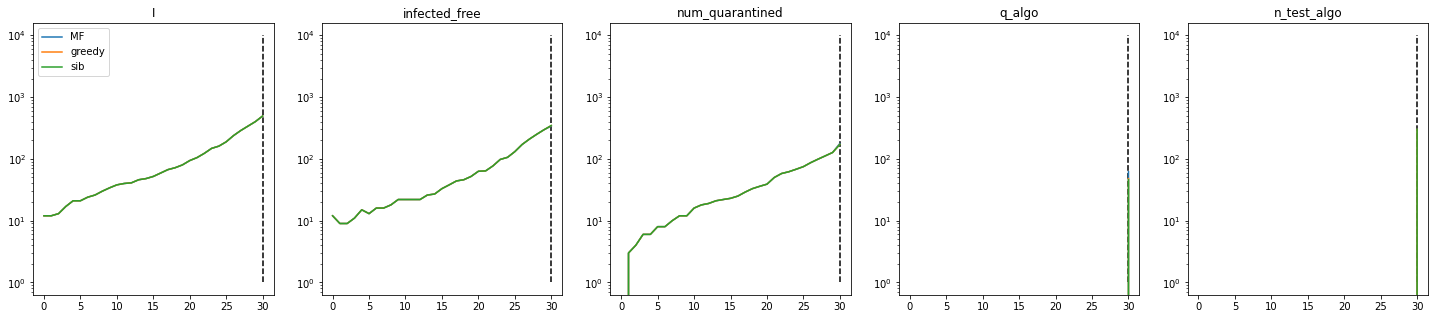

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
to_plot = ['I', 'infected_free', 'num_quarantined', "q_algo", "n_test_algo"]
for s in ress.keys():
    for il, l in enumerate(to_plot):
        if s != "no_intervention":
            axs[il].plot(range(T), ress[s][l], label=s)
            if l != "aurI":
                axs[il].set_yscale("log")
                axs[il].vlines(initial_steps, ymin=1, ymax=10**4,
                               linestyle="--", alpha=0.5, color="black")
            else:
                axs[il].vlines(initial_steps, ymin=0, ymax=1,
                               linestyle="--", alpha=0.5, color="black")

            axs[il].set_title(l, fontsize=12)
    axs[0].legend(loc='upper left')

#fig.suptitle(f"num test algo {num_test_algo} - adoption_fraction {adoption_fraction}")
fig.show()


In [7]:
import pandas as pd

filename = f"sib_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}_states.pkl"

object = pd.read_pickle(output_dir + filename)
#object['transmissions']

In [13]:
x, y = object["ROC"][30]

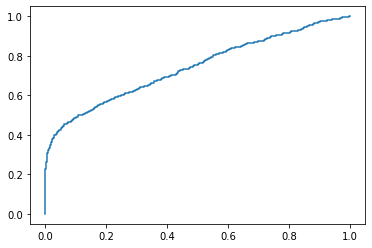

In [14]:
plt.plot(x,y)

In [15]:
prec, recall = object["PPV"][30]

In [16]:
len(recall)

90392

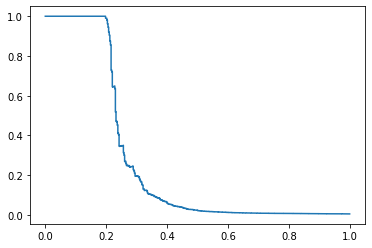

In [17]:
plt.plot(recall,prec)